In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from arguments import parse_args
from main import train, get_data
from dataset import LocalizationDataset
from torch.utils.data import DataLoader
import os
from cust_model import Tracker, TrackingDataset
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [56]:
from import_data import grab_amazon_data

inputs_prebatch, outputs_prebatch = grab_amazon_data()

1


In [61]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict({"num_trajs":807,
        "sl":96,
        "batch_size":128,
        "num_particles":30,
        "window_length":6,
        "h":64,
        "emb_obs":23,
        "emb_act":32,
        "dropout":0.5, #we changed this from 0.5
        "obs_num":5,
        "resamp_alpha":0.5,
        "bp_length":10, 
        "clip":1.0,
        "lr":0.0005,
        "bpdecay":0.1,
        "l2_weight":1.0,
        "l1_weight":0.0})

In [62]:
train_dataset = TrackingDataset(inputs_prebatch, outputs_prebatch)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                            num_workers=8, pin_memory=True, shuffle=False, drop_last = True)
model = Tracker(args)
optimizer = torch.optim.RMSprop(model.parameters(), lr=args.lr)

In [63]:
cnt = 0
best_eval = 1000
from tqdm import tqdm

losses = []

print("starting epochs")
for epoch in tqdm(range(10)):
    per_e_loss = []
    # print("going to train")
    model.train() #just a toggle switch

    # print("starting iterations")
    for iteration, data in enumerate(train_loader):
        cnt = cnt + 1

        output, window = data
        model.zero_grad()
        loss, log_loss, particle_pred = model.step(
            window, output, args)
        loss.backward()

        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()

        loss_last = log_loss.to('cpu').detach().numpy()
        loss_all = loss.to('cpu').detach().numpy()
        per_e_loss.append([loss_last, loss_all])
    losses.append(per_e_loss)


starting epochs


100%|██████████| 10/10 [10:01<00:00, 60.13s/it]


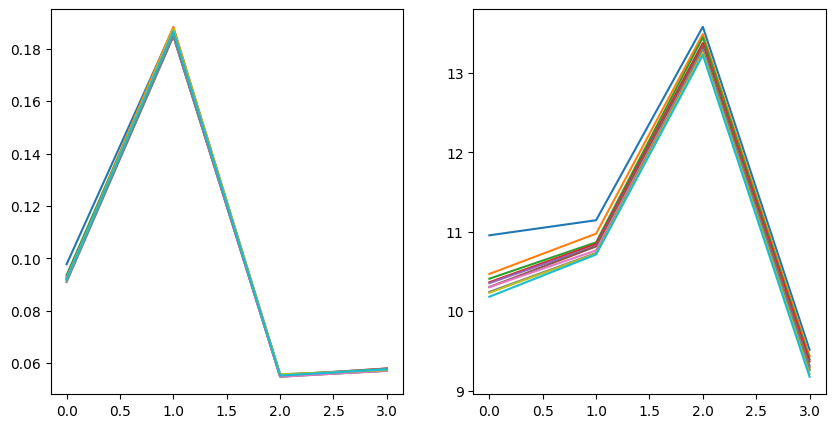

In [64]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize = (10,5))
for lidx, lnp in enumerate(losses):
    lnp = np.array(lnp)
    ax0.plot(lnp[:,0], label = f"{lidx}_loss")
    ax1.plot(lnp[:,1], label = f"{lidx}_loss_last")